In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn import plotting
import nibabel as nib
import pandas as pd
from nipy import load_image
import numpy as np

In [3]:
#import os
#os.listdir('/srv/local/mricron-gtk1-20101203/templates')

## MNI Coordinates to AAL

In [4]:
all_md_regions = nib.load('../data_inhouse_fmri/data_rois/MDROI_sized.nii')
all_md_regions_data = all_md_regions.get_data();

In [5]:
all_md_regions.affine

array([[  -2.,    0.,    0.,   78.],
       [   0.,    2.,    0., -112.],
       [   0.,    0.,    2.,  -50.],
       [   0.,    0.,    0.,    1.]])

In [6]:
def MNI_coordinate_to_md_index(coord,myimg):
    return(np.dot(np.linalg.inv(myimg.affine),coord))

MNI_coordinate_to_md_index(np.array([-38,38,38,1]),all_md_regions)

array([ 58.,  75.,  44.,   1.])

In [7]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm')

In [8]:
# ## Get AAL image
# dataset = datasets.fetch_atlas_aal()
# atlas_filename = dataset.maps
# dataset.indices
# dataset.indices.append('0')
# dataset.labels
# dataset.labels.append('Outside Brain')
# atlas_img = nib.load(dataset.maps)
# atlas_img_data = atlas_img.get_data()
# print(atlas_img.affine)

In [9]:
# print(dataset.labels[0:4])
# print(dataset.indices[0:4])

In [10]:
mdnames = {}
mdnames['13350']='IFGop_R'
mdnames['12136']='IFGop_L'
mdnames['10922'] = 'Insula_R'
mdnames['9709'] = 'Insula_L'
mdnames['27913'] = 'MFGorb_R'
mdnames['25485'] = 'MFGorb_L'
mdnames['14563'] = 'ACC'
mdnames['16990'] = 'PrecG_R'
mdnames['15777'] = 'PrecG_L'
mdnames['29126'] = 'MFG_R'
mdnames['26699'] = 'MFG_L'



### Read in v7

In [11]:
# read data set in 
df= pd.read_csv("../data_meta_analysis/Data_Classifications_v7.csv")
df['MNI.Coordinates'].unique()[0:5]


array([nan, '3,53,-20', '60,17,34', '-35, 19, 3; 35, 19, 3', '0, 23, 39'], dtype=object)

In [12]:

## convert each MNI coordinate into a region name, and concatenate each rows names. 
for i,c in enumerate(df['MNI.Coordinates']):
    if isinstance(c, basestring):
        cc = c.split(';')
        rnames = []
        
        for s,single_coord in enumerate(cc):
            single_coord = single_coord.replace('_','') # replace underscores
            single_coord = single_coord.replace('\x05','') # replace underscores
            #try:
            single_coord = np.array([float(x) for x in single_coord.split(',')]) # convert each number to float
            #array_of_coords.append(single_coord) # append each entries 1 to multiple single coordinates 
            #except:
            #    print(single_coord)
            single_coord = np.append(single_coord,1) # padd with a 1 for the affine transform
            vindex = MNI_coordinate_to_md_index(single_coord,all_md_regions)  # convert to AAL voxel indices
            vindex = vindex.astype('int')
            rindex = all_md_regions_data[vindex[0],vindex[1],vindex[2]] # find the code for the region in the map
            #print(rindex)
            try:
                name = mdnames[str(rindex)]
                
            except:
                name = 'Outside_MD'
            rnames.append(name)  # convert the code into region name 
        
            #print(rnames)
        df.loc[i,'Region.MD.1']=";".join(rnames)
            #print(rindex)

In [13]:
df['Region.MD.1'].unique()

array([nan, 'Outside_MD', 'Insula_R;Insula_L', 'ACC', 'MFG_R;MFG_L',
       'Insula_R', 'IFGop_L', 'PrecG_L', 'PrecG_R', 'MFG_L;MFG_R',
       'Insula_L;Insula_R', 'MFG_R', 'IFGop_R', 'ACC;ACC', 'MFG_L',
       'IFGop_R;IFGop_L', 'Outside_MD;Outside_MD', 'Insula_L',
       'Outside_MD;ACC', 'IFGop_L;IFGop_L', 'Outside_MD;PrecG_L',
       'Outside_MD;MFG_L', 'MFGorb_R',
       'ACC;ACC;PrecG_R;IFGop_L;MFG_R;Outside_MD;IFGop_R;IFGop_L'], dtype=object)


## Name Conversions

### AAL

In [14]:
aal = datasets.fetch_atlas_aal()


aal.indices
aal.indices.append('0')
aal.labels
aal.labels.append('Outside Brain')

aal_img = nib.load(aal.maps)
aal_img_data = aal_img.get_data()

In [15]:
def AALtoMD(AALname,aal,aal_img,aal_img_data,mdnames,all_md_regions_data):
    boolindex = [label==AALname for label in aal.labels]
    AALnumber = np.array(aal.indices)[boolindex][0]
    coords = np.where(aal_img_data==int(AALnumber))
    coords = np.vstack((coords[0],coords[1],coords[2]))
    rnames = []
    for ci in range(np.shape(coords)[1]):
        coord = coords[:,ci]
        MNIcoord = np.dot(aal_img.affine,np.append(coord,1.0))
        MDindex = MNI_coordinate_to_md_index(MNIcoord,all_md_regions)
        vindex = MDindex.astype('int')
        rindex = all_md_regions_data[vindex[0],vindex[1],vindex[2]] # find the code for the region in the map
        #print(rindex)
        try:
            name = mdnames[str(rindex)]
            rnames.append(name)  # convert the code into region name 

        except:
            x=1

    rnames = list(set(rnames))
    if rnames:
        rnames = ';'.join(rnames)
    else:
        rnames = None
    return(rnames)

In [16]:

for i,c in enumerate(df['AAL']):
    
    if isinstance(c, basestring):
        # create region list     
        cc = c.split(';')
        rnames = []
        for s,AAL in enumerate(cc):
            AAL = AAL.replace(' ','')
            rnames = rnames +  [AALtoMD(AAL,aal,aal_img,aal_img_data,mdnames,all_md_regions_data)]
        
        # remove duplicates using set and make single string # 
        rnames = [r for r in rnames if r is not None]
        
        if not rnames:
            rnames = ['Outside_MD']
        
        region_str = ';'.join(list(set(rnames))) 
        #print(c)
        #print(region_str)

        # save to dataframe
        df.loc[i,'Region.MD.1']=region_str# set removes duplicates, then makes it all into a string

### BA

In [17]:

BAtoAAL = {}

BAtoAAL['6'] = 'PrecG_L; PrecG_R' #
BAtoAAL['8'] = 'Outside_MD' #
BAtoAAL['9'] =  'Outside_MD' #
BAtoAAL['10'] ='MFGorb_R; MFGorb_L'
BAtoAAL['11'] ='Outside_MD' #
BAtoAAL['12'] = 'Outside_MD' #
BAtoAAL['13'] ='Outside_MD' #
BAtoAAL['14'] = 'Outside_MD' #

# these are straight
BAtoAAL['47'] = 'Insula_R; Insula_L' #
BAtoAAL['45'] = 'Insula_R; Insula_L' #
BAtoAAL['44'] = 'IFGop_R; IFGop_L' #
BAtoAAL['46'] = 'MFG_R; MFG_L' #
BAtoAAL['24'] = 'ACC' #
BAtoAAL['32'] = 'ACC' #


In [18]:
remove_left=True
remove_right=False


# remove left and right if they are not in the name
exclude_index = []
for n,name in enumerate(rnames):
    if 'R' in name and remove_right:  
        exclude_index=exclude_index+[n]
    if 'L' in name and remove_left: 
        exclude_index=exclude_index+[n]
        
rnames = [element for i, element in enumerate(rnames) if i not in exclude_index]

In [19]:
for i,c in enumerate(df['BA']):

    if isinstance(c, basestring):

        # create region list     
        cc = c.split(',')
        rnames = []
        for s,BA in enumerate(cc):
            BA = str(int(BA)) # gets rid of spaces
            rnames = rnames +  BAtoAAL[BA].split(';') # add to list
            

        # determine if BA is right, left, or both
        region_name = df.loc[i,'Region.name']
        if isinstance(region_name, basestring):
            if ' R' in region_name or 'Right' in region_name or 'right' in region_name:
                remove_left=True # if the name contains R, then remove left 
            else:
                remove_left=False

            if ' L' in region_name or 'Left' in region_name or 'left' in region_name:
                remove_right=True
            else:
                remove_right=False        

        # remove left and right if they are not in the name
        exclude_index = []
        for n,name in enumerate(rnames):
            if 'R' in name and remove_right:  
                exclude_index=exclude_index+[n]
            if 'L' in name and remove_left: 
                exclude_index=exclude_index+[n]


        rnames = [element for ii, element in enumerate(rnames) if ii not in exclude_index]
        

        
        # remove duplicates using set and make single string # 
        region_list = list(set(rnames))
        if len(region_list)>1:
            region_list = [r for r in region_list if r is not 'Outside_MD']
        
        region_list = ';'.join(region_list) 
        
        #print(region_list)
        
        # save to dataframe
        df.loc[i,'Region.MD.1']=region_list# set removes duplicates, then makes it all into a string

In [20]:
#df.loc[df['BA'].notnull(),['Region.name','BA','Region.AAL.1']]

### OxHarvard

In [21]:
OxHarvard = {}


OxHarvard['DLPFC'] = 'MFG_R; MFG_R' #
OxHarvard['dorsal premotor'] = 'PrecG_L; PrecG_R' #
OxHarvard['ventral premotor']= 'PrecG_L; PrecG_R' #
OxHarvard['SMA'] = 'PrecG_L; PrecG_R' #
OxHarvard['pre SMA'] = 'PrecG_L; PrecG_R' #
OxHarvard['ventrolateral PFC'] ='Insula_R; Insula_L' #



In [22]:
for i,c in enumerate(df['OxHarvard']):
    if isinstance(c, basestring):
        cc = c.split(',')
        rnames = []
        for s,BA in enumerate(cc):
            rnames = rnames +  OxHarvard[BA].split(';') # add to list
        #print(c)
        #print(rnames)
        df.loc[i,'Region.MD.1']=';'.join(list(set(rnames))) # set removes duplicates, then makes it all into a string

In [23]:
df.loc[df['OxHarvard'].notnull(),['Region.name','OxHarvard','Region.MD.1']].head()

,Region.name,OxHarvard,Region.MD.1
581,DLPFC,DLPFC,MFG_R;MFG_R
582,dorsal premotor,dorsal premotor,PrecG_R;PrecG_L
583,SMA,SMA,PrecG_R;PrecG_L
584,SMA,SMA,PrecG_R;PrecG_L
585,SMA,SMA,PrecG_R;PrecG_L


### Desikan

In [24]:
desikan = {}

desikan['LPFC L'] = 'MFG_L'
desikan['LPFC R'] = 'MFG_R'
desikan['Bi-lateral LPFC'] = 'MFG_R; MFG_L' 
# these were explicitly listed in paper 7 

desikan['Caudal Anterior Cingulate'] = 'ACC'
desikan['Rostral Anterior Cingulate'] = 'ACC'


desikan['Pars Opercularis'] ='IFGop_R; IFGop_L'

desikan['Pars Triangularis']='Insula_R; Insula_L'
desikan['Pars Orbitalis'] = 'Insula_R; Insula_L'
desikan['Lateral Orbitofrontal'] = 'Outside_MD'

desikan['Superior Frontal'] = 'Outside_MD'
desikan['Caudal Middle Frontal'] ='MFG_R; MFG_L'
desikan['Caudal Mid Frontal'] = 'MFG_R; MFG_L'

desikan['Rostral Mid Frontal'] = 'MFGorb_R; MFGorb_L'
desikan['Rostral Middle Frontal'] = 'MFGorb_R; MFGorb_L'

desikan['Frontal Pole'] ='MFGorb_R; MFGorb_L'

desikan['Insula'] = 'Insula_R; Insula_L'





In [25]:
for i,c in enumerate(df['Desikan']):
    if isinstance(c, basestring):
        cc = c.split(',')
        rnames = []
        for s,BA in enumerate(cc):
            BA = BA.rstrip() # remove trailing white space
            rnames = rnames +  desikan[BA].split(';') # add to list
        #print(c)
        #print(rnames)
        df.loc[i,'Region.MD.1']=';'.join(list(set(rnames))) # set removes duplicates, then makes it all into a string

In [26]:
df.loc[df['Desikan'].notnull(),['Region.name','Desikan','Region.MD.1']].head()

,Region.name,Desikan,Region.MD.1
104,Pars Opercularis,Pars Opercularis,IFGop_L;IFGop_R
105,Caudal Anterior Cingulate_,Caudal Anterior Cingulate,ACC
106,Rostral Anterior Cingulate_,Rostral Anterior Cingulate,ACC
107,Caudal Middle Frontal_,Caudal Middle Frontal,MFG_L;MFG_R
108,Frontal Pole_,Frontal Pole,MFGorb_R; MFGorb_L


### Destrieux

In [27]:
destrieux = {}
destrieux['premotor'] = 'PrecG_L; PrecG_R'

In [28]:
for i,c in enumerate(df['Destrieux']):
    if isinstance(c, basestring):
        cc = c.split(',')
        rnames = []
        for s,BA in enumerate(cc):
            BA = BA.rstrip() # remove trailing white space
            rnames = rnames +  destrieux[BA].split(';') # add to list
        #print(c)
        #print(rnames)
        df.loc[i,'Region.MD.1']=';'.join(list(set(rnames))) # set removes duplicates, then makes it all into a string

In [29]:
df.loc[df['Destrieux'].notnull(),['Region.name','Destrieux','Region.MD.1']].head()

,Region.name,Destrieux,Region.MD.1
572,premotor,premotor,PrecG_R;PrecG_L
573,premotor,premotor,PrecG_R;PrecG_L
574,premotor,premotor,PrecG_R;PrecG_L


### No Atlas Specified

In [30]:
unknown = {}


unknown['SMA']= 'PrecG_L; PrecG_R'
unknown['LOper'] = 'IFGop_L'
unknown['ROper'] = 'IFGop_R'
unknown['LTria'] = 'Insula_L'
unknown['RTria'] = 'Insula_R'
unknown['FO'] ='Insula_R; Insula_L'
unknown['MFC'] = 'MFG_R; MFG_L'
unknown['SEF'] ='Outside_MD'
unknown['lFEF'] = 'PrecG_L; PrecG_R'
unknown['mPFC'] = 'Outside_MD'
unknown['Insula']= 'Insula_L; Insula_R'
unknown['mSFG']= 'Outside_MD'
unknown['MFG']= 'MFG_R; MFG_L'
unknown['Frontal'] = 'Outside_MD'
unknown['lPFC']= 'MFG_R; MFG_L'
unknown['Superior frontal sulcus'] = 'Outside_MD'
unknown['FEF'] = 'Outside_MD'
unknown['bilateral FEF'] = 'Outside_MD'
unknown['RFEF'] ='Outside_MD'
unknown['Cingulate'] = 'ACC'
unknown['rACC R'] = 'ACC'
unknown['rACC'] = 'ACC'
unknown['dACC L'] = 'ACC'
unknown['ACC'] =  'ACC'
unknown['Medial prefrontal'] = 'Outside_MD'
unknown['left medial frontal gyrus'] =  'Outside_MD'
unknown['Anterior Insula L'] = 'Insula_L'
unknown['Anterior Insula R'] = 'Insula_R'
unknown['INS'] = 'Insula_L; Insula_R'
unknown['Anterior Insula R'] = 'Insula_R'
unknown['left inferior frontal gyrus'] = 'Insula_L'
unknown['right inferior frontal gyrus'] = 'Insula_R'
unknown['IFG'] = 'Insula_L; Insula_R'
unknown['DLPFC'] = 'MFG_L; MFG_R'
unknown['DLFPC'] = 'MFG_L; MFG_R'
unknown['Dorsolateral PFC'] = 'MFG_L; MFG_R'
unknown['left DLPFC']  = 'MFG_L; MFG_R'
unknown['LDLPFC']  = 'MFG_L'
unknown['RDLPFC'] = 'MFG_R'
unknown['right DLPFC']  = 'MFG_R'
unknown['left middle frontal gyrus']='MFG_L'
unknown['anterior regions of left lateral PFC'] = 'MFGorb_L; MFGorb_R'
unknown['OFC'] = 'Outside_MD'
unknown['orbitofrontal cortex'] = 'Outside_MD'
unknown['mOFC'] = 'Outside_MD'
unknown['LOFC'] ='Outside_MD'
unknown['right PMC'] ='PrecG_R'
unknown['medial frontopolar'] = 'Outside_MD'




In [31]:
for i,c in enumerate(df['Unkown Atlas']):
    if isinstance(c, basestring):
        cc = c.split(',')
        rnames = []
        for s,BA in enumerate(cc):
            BA = BA.rstrip() # remove trailing white space
            rnames = rnames +  unknown[BA].split(';') # add to list
        #print(c)
        #print(rnames)
        df.loc[i,'Region.MD.1']=';'.join(list(set(rnames))) # set removes duplicates, then makes it all into a string

In [32]:
df.loc[df['Unkown Atlas'].notnull(),['Region.name','Unkown Atlas','Region.MD.1']].head()

,Region.name,Unkown Atlas,Region.MD.1
38,NaN,FEF,Outside_MD
42,Medial prefrontal,Medial prefrontal,Outside_MD
43,Medial prefrontal,Medial prefrontal,Outside_MD
44,Medial prefrontal,Medial prefrontal,Outside_MD
45,Cingulate,Cingulate,ACC


### Outside brain fixes

In [33]:
print(df.loc[df['Region.MD.1']=='Outside Brain','Region.name']) # print the outside of the brain.
print(len(df.loc[df['Region.MD.1']=='Outside Brain','Region.name']))

Series([], Name: Region.name, dtype: object)
0


In [34]:
# df.loc[(df['Region.AAL.1']=='Outside Brain')&(df['PID']==42),'Region.MD.1']=['Frontal_Inf_Tri_R; Frontal_Inf_Tri_L; Frontal_Mid_L; Frontal_Mid_R',
#                                                             'Frontal_Inf_Tri_R; Frontal_Inf_Tri_L; Frontal_Mid_L; Frontal_Mid_R']

In [35]:
## other mscl fixes 
# df.loc[df['Region.AAL.1']=='; Frontal_Inf_Oper_L;Frontal_Inf_Oper_R',['Region.AAL.1']] = 'Frontal_Inf_Oper_L;Frontal_Inf_Oper_R'
# df.loc[df['Region.AAL.1']==';Frontal_Mid_Orb_R; Frontal_Inf_Orb_L;Frontal_Sup_Orb_L;Frontal_Inf_Orb_L;Frontal_Sup_Orb_R; Frontal_Mid_Orb_L'
#        ,['Region.AAL.1']]= 'Frontal_Mid_Orb_R; Frontal_Inf_Orb_L;Frontal_Sup_Orb_L;Frontal_Inf_Orb_L;Frontal_Sup_Orb_R; Frontal_Mid_Orb_L'

## Save a CSV with region

In [36]:
df.to_csv('../data_meta_analysis/data_derived_meta_analysis/Data_Classifications_v7_with_region_md.csv',index=False)
df= pd.read_csv("../data_meta_analysis/data_derived_meta_analysis/Data_Classifications_v7_with_region_md.csv")

## Create a region design (X) Matrix

In [37]:
labels = [mdnames[key] for key in mdnames.keys()]
labels = np.array(np.sort(labels))
labels = np.append(labels,np.array(['Outside_MD']))
labels

array(['ACC', 'IFGop_L', 'IFGop_R', 'Insula_L', 'Insula_R', 'MFG_L',
       'MFG_R', 'MFGorb_L', 'MFGorb_R', 'PrecG_L', 'PrecG_R', 'Outside_MD'], 
      dtype='|S10')

In [38]:
# create X matrix for region

X = np.zeros((len(df),len(labels))) # make it the size of the entire AAL list

# go through each row of dataset,and for each name in the string, find the location in the region name in the list
for i,c in enumerate(df['Region.MD.1']):
    if isinstance(c, basestring):
        cc = c.split(';')
        for single_name in cc:
            #print(single_name)
            single_name = single_name.lstrip()
            X[i,labels==single_name]=1

# remove the labels with no ones
labels =np.array(labels)
labels =labels[X.sum(0)!=0]
# now remove row's with no region. 
X = X[:,X.sum(0)!=0]




In [39]:
labels[X.sum(0)!=0]

array(['ACC', 'IFGop_L', 'IFGop_R', 'Insula_L', 'Insula_R', 'MFG_L',
       'MFG_R', 'MFGorb_L', 'MFGorb_R', 'PrecG_L', 'PrecG_R', 'Outside_MD'], 
      dtype='|S10')

In [40]:
# make design matrix into a dataframe 
d = pd.DataFrame(X)
d.columns = labels
d.head()

,ACC,IFGop_L,IFGop_R,Insula_L,Insula_R,MFG_L,MFG_R,MFGorb_L,MFGorb_R,PrecG_L,PrecG_R,Outside_MD
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


### Plot Design Matrix

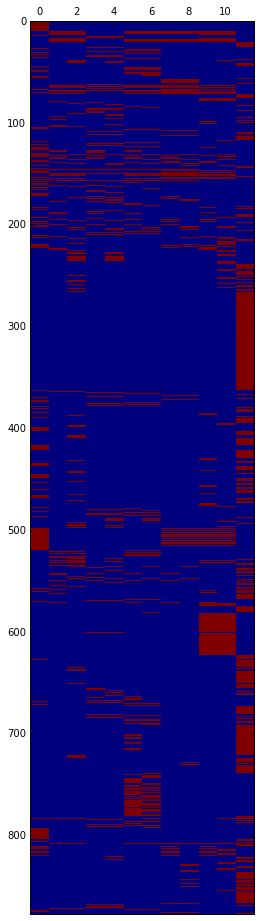

In [41]:
plt.matshow(X,aspect='auto')

### Rows that have no region..

In [42]:
(d.sum(1)==0).sum()

0

In [43]:
df.loc[(d.sum(1)==0)]

,PID,Title,Info.type,Source.in.paper,Task.variable.decoded,Accuracy.50,Accuracy.other,Num_classes,Significance,Roi.Search,...,ROI.Atlas,BA,AAL,Desikan,OxHarvard,Destrieux,Unkown Atlas,Method.of.Assigning.Region,Region.name,Region.MD.1


### Save X

In [44]:
d.to_csv('../data_meta_analysis/data_derived_meta_analysis/X_region1_2_md.csv',index=None)

In [45]:
print('done')

done
